In [40]:
import cvxopt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as ptc 
import os
import shutil
import cv2
from glob import *
#xy = (10, 10), radius = 1, alpha = 0.5, animated = True, color = 'aqua', edgecolor = 'orange'

<img src="motivation.png" alt="Drawing" style="width: 800px;"/>
<img src="formulation.png" alt="Drawing" style="width: 800px;"/>
<img src="constraints.png" alt="Drawing" style="width: 800px;"/>

In [42]:

def frames_to_video(input_path, output_path, fps):
    '''
        Function to Concatenate given frames and fps into a video file.
        Input Arguments
        input_path  : Path to the input directory containing input frames
        output_path : Path to the output directory containing the video file
        fps         : Frames per Second of the output video
        Return
        Boolean     : True is Video written successfully, False if writing is not successful.
    '''
    image_files = glob(input_path)
    #print(image_files)    
    
    image_files = glob(input_path)
    final = len(image_files)
    location = './plots_temp'  #./plots_temp_holo_wheel"
    frames = [] 
    for f in range(0 + 1, 1 + final):
#         print(f)
        frame = cv2.imread(f"{location}/{f}.png")
#         print(f"{location}/{f}.png")
        height, width, channels = frame.shape
        size = (width, height)
        frames.append(frame)
        if f == final:
            for endingFrame in range(5):
                frames.append(frame)

    video_writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
    for frame in frames:
        video_writer.write(frame)

    video_writer.release()
    return True

In [56]:
t_del = 1
v_init = np.array([10,10])

class MPC_Agent:
    def __init__(self, start, goal, steps, vmax):
        self.xpath = []
        self.ypath = []
        self.time = 0
        self.pos = start
        self.goal = goal
        self.v = v_init
        self.steps = steps
        self.vmax = vmax
        
    def get_linear_const(self, obstParams):
        #obstParams = x_ob, y_ob, R.
        #To get the linear collision cone constraint using the taylor expansion.
        fx_star = - (self.x - obstParams[0]) ** 2 - (self.y - obstParams[1]) ** 2 + obstParams[2] ** 2
        linConstG = np.array([-2 * self.x - 2 * obstParams[0], -2 * self.y - 2 * obstParams[1]])
        linConsth = - fx_star - self.y * (2 * self.y + obstParams[1]) - self.x * (2 * self.x + obstParams[0])
        #gx <= h -> x is a 2X1 vector [x, y]
        
        
    def traj_opti(self):
#         print("start Vx: ", self.v[0], "start Vy: ", self.v[1])
       
        x = (t_del ** 2) * np.vstack((np.hstack((np.ones((self.steps, self.steps)), np.zeros((self.steps, self.steps)))), np.hstack((np.zeros((self.steps, self.steps)), np.ones((self.steps, self.steps))))))
#         print(x.shape)
        P = float(2) * cvxopt.matrix(x, tc = 'd')
        kx = self.pos[0] - self.goal[0]
        ky = self.pos[1] - self.goal[1]
        Q_mat_x = float(kx) * np.ones((self.steps,1))
        Q_mat_y = float(ky) * np.ones((self.steps,1))
        Q_mat = float(2.0 * t_del) * np.vstack((Q_mat_x, Q_mat_y))
        Q = cvxopt.matrix(Q_mat, tc = 'd')
#         print(Q.size)
        G_mat_x = np.zeros((4 * self.steps, 2 * self.steps))
        for i in range(0, self.steps):
            G_mat_x[i][i] = -1
            G_mat_x[i + self.steps][i] = 1
            G_mat_x[i + 2*self.steps][i+self.steps] = -1
            G_mat_x[i + 3*self.steps][i+self.steps] = 1
        H_mat_x = np.zeros((4 * self.steps, 1))
        
        '''
        can be replaced with numpy commands - -np.eye, np.vstack, np.hstack
        '''
        
        for i in range(0, self.steps):
            H_mat_x[i] = 0
            H_mat_x[i + self.steps] = self.vmax
            H_mat_x[i + 2*self.steps] = 0
            H_mat_x[i + 3*self.steps] = self.vmax
        G = cvxopt.matrix(G_mat_x, tc = 'd')
        H = cvxopt.matrix(H_mat_x, tc = 'd')
#         print(G.size, H.size)
        sol = cvxopt.solvers.qp(P,Q,G,H,options={'show_progress': False})
        
        if os.path.isdir("./plots_temp"):
            shutil.rmtree("./plots_temp")
        os.mkdir("./plots_temp")  
        
        if os.path.isdir("./cc_plots_temp"):
            shutil.rmtree("./cc_plots_temp")
        os.mkdir("./cc_plots_temp")  
    
        for i in range(0,self.steps):
            x_i = self.pos[0] + sol['x'][i] * t_del
            y_i = self.pos[1] + sol['x'][i + self.steps] * t_del
            
            #print(sol['x'])
            
            print(sol['x'][i])
            print(sol['x'][i + self.steps])
            self.xpath.append(x_i.astype('float'))
            self.ypath.append(y_i.astype('float'))
            self.pos[0] = x_i
            self.pos[1] = y_i
#             print(self.pos[0], self.pos[1])
            print('----------------------------------------------')
            self.time += 1
            print(self.time, self.pos[0], self.pos[1])
            self.cc_visualize_traj() 
#         frames_to_video("./plots_temp/*.png", "./Quadratic-programming-control.mp4", 10)
    
    def visualize_traj(self):
        plt.plot(self.pos[0], self.pos[1], '^',color = 'orangered', markersize = 20)
        plt.plot(self.goal[0], self.goal[1], '^',color = 'lawngreen', markersize = 20)
        plt.title("Timestamp " + str(self.time), fontsize = 20, color = 'green')
        x_path = np.array(self.xpath)
        y_path = np.array(self.ypath)
        plt.plot(x_path, y_path, color = 'gold')
#         plt.axis('off')
        plt.xticks(x_path, " ")
        plt.yticks(y_path, " ")
        plt.savefig("./plots_temp/" + str(self.time) + ".png")

        plt.show()
        
    def cc_visualize_traj(self):
        fig, ax = plt.subplots(figsize = (12,12))
        
#         fig = plt.figure(figsize=(8, 6))
        ax.plot(self.pos[0], self.pos[1], '^',color = 'orangered', markersize = 20)
        ax.plot(self.goal[0], self.goal[1], '^',color = 'lawngreen', markersize = 20)
#         a_circle = ptc.Circle(xy = (10, 10), radius = 1, alpha = 0.5, animated = True, color = 'aqua', edgecolor = 'orange' )
        a_circle = plt.Circle(xy = (10, 10), radius = 1, alpha = 0.5, animated = True, color = 'aqua', edgecolor = 'orange' )
        ax.set_aspect( 1 )
        ax.add_artist(a_circle)
        fig.suptitle("Timestamp " + str(self.time), fontsize = 20, color = 'green')
        x_path = np.array(self.xpath)
        y_path = np.array(self.ypath)
        ax.plot(x_path, y_path, color = 'gold')
#         plt.axis('off')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
#         ax.savefig("./cc_plots_temp/" + str(self.time) + ".png")

        fig.show()

0.350000074534626
0.6000000359802307
----------------------------------------------
1 1.3500000745346261 1.6000000359802307
0.35000007453462667
0.6000000359616041
----------------------------------------------
2 1.7000001490692527 2.200000071941835
0.3500000745346267
0.6000000359614123
----------------------------------------------
3 2.0500002236038792 2.800000107903247
0.3500000745346261
0.6000000359614137
----------------------------------------------
4 2.4000002981385054 3.400000143864661
0.3500000745346258
0.6000000359612256
----------------------------------------------
5 2.750000372673131 4.000000179825887
0.3500000745346603
0.6000000359612266
----------------------------------------------
6 3.1000004472077913 4.600000215787113
0.35000007453462567
0.6000000359612264
----------------------------------------------
7 3.450000521742417 5.20000025174834
0.3500000745346601
0.6000000359612273
----------------------------------------------
8 3.8000005962770773 5.800000287709567
0.3500000

<ipython-input-56-f0c1679b8e7b>:107: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  a_circle = plt.Circle(xy = (10, 10), radius = 1, alpha = 0.5, animated = True, color = 'aqua', edgecolor = 'orange' )
<ipython-input-56-f0c1679b8e7b>:119: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-56-f0c1679b8e7b>:107: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  a_circle = plt.Circle(xy = (10, 10), radius = 1, alpha = 0.5, animated = True, color = 'aqua', edgecolor = 'orange' )
<ipython-input-56-f0c1679b8e7b>:119: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-56-f0c1679b8e7b>:107: UserWarning: Setting the 'color' property will override the edgecolor or facecolo

0.35000007453466103
0.6000000359614149
----------------------------------------------
12 5.200000894415722 8.200000431555226
0.3500000745311563
0.600000035961227
----------------------------------------------
13 5.550000968946878 8.800000467516453
0.3500000745346262
0.6000000359610386
----------------------------------------------
14 5.900001043481504 9.400000503477491
0.3500000745311563
0.6000000359612273
----------------------------------------------
15 6.25000111801266 10.000000539438718
0.3500000745311562
0.6000000359610389
----------------------------------------------
16 6.600001192543816 10.600000575399756
0.3500000745311553
0.6000000359612253
----------------------------------------------
17 6.950001267074971 11.20000061136098
0.35000007453112075
0.600000035961225
----------------------------------------------
18 7.300001341606092 11.800000647322205


<ipython-input-56-f0c1679b8e7b>:119: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-56-f0c1679b8e7b>:107: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  a_circle = plt.Circle(xy = (10, 10), radius = 1, alpha = 0.5, animated = True, color = 'aqua', edgecolor = 'orange' )
<ipython-input-56-f0c1679b8e7b>:119: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-56-f0c1679b8e7b>:107: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  a_circle = plt.Circle(xy = (10, 10), radius = 1, alpha = 0.5, animated = True, color = 'aqua', edgecolor = 'orange' )
<ipython-input-56-f0c1679b8e7b>:119: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inlin

0.3500000745311554
0.6000000359424141
----------------------------------------------
19 7.650001416137247 12.40000068326462
0.35000007453115567
0.600000035961226
----------------------------------------------
20 8.000001490668403 13.000000719225847
0.3500000745346259
0.6000000359424136
----------------------------------------------
21 8.350001565203028 13.60000075516826
0.35000007453462506
0.6000000359424127
----------------------------------------------
22 8.700001639737653 14.200000791110673
0.3500000745346599
0.6000000359424129
----------------------------------------------
23 9.050001714272314 14.800000827053086
0.35000007453462495
0.6000000359424131
----------------------------------------------
24 9.40000178880694 15.4000008629955
0.3500000745345907
0.6000000359424161
----------------------------------------------
25 9.75000186334153 16.000000898937916
0.3500000745346255
0.6000000359424162
----------------------------------------------
26 10.100001937876156 16.60000093488033
0.35

<ipython-input-56-f0c1679b8e7b>:107: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  a_circle = plt.Circle(xy = (10, 10), radius = 1, alpha = 0.5, animated = True, color = 'aqua', edgecolor = 'orange' )
<ipython-input-56-f0c1679b8e7b>:119: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-56-f0c1679b8e7b>:101: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize = (12,12))
<ipython-input-56-f0c1679b8e7b>:107: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  a_circle = plt.Circle(xy = (10, 10), radius = 1, alpha = 0.5, animated = Tr

0.3500000745345907
0.6000000359612281
----------------------------------------------
31 11.85000231054918 19.60000111463003
0.3500000745345908
0.6000000359424162
----------------------------------------------
32 12.20000238508377 20.200001150572444
0.3500000745311206
0.6000000359424159
----------------------------------------------
33 12.550002459614891 20.80000118651486
0.35000007453112036
0.6000000359424159
----------------------------------------------
34 12.900002534146012 21.400001222457274
0.3500000745311206
0.600000035961228
----------------------------------------------
35 13.250002608677132 22.0000012584185
0.35000007453112025
0.6000000359612279
----------------------------------------------
36 13.600002683208253 22.600001294379727
0.35000007453112036
0.6000000359612275
----------------------------------------------
37 13.950002757739373 23.200001330340953
0.3500000745311205
0.6000000359612279
----------------------------------------------
38 14.300002832270494 23.800001366302

<ipython-input-56-f0c1679b8e7b>:119: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-56-f0c1679b8e7b>:101: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize = (12,12))
<ipython-input-56-f0c1679b8e7b>:107: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  a_circle = plt.Circle(xy = (10, 10), radius = 1, alpha = 0.5, animated = True, color = 'aqua', edgecolor = 'orange' )
<ipython-input-56-f0c1679b8e7b>:119: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


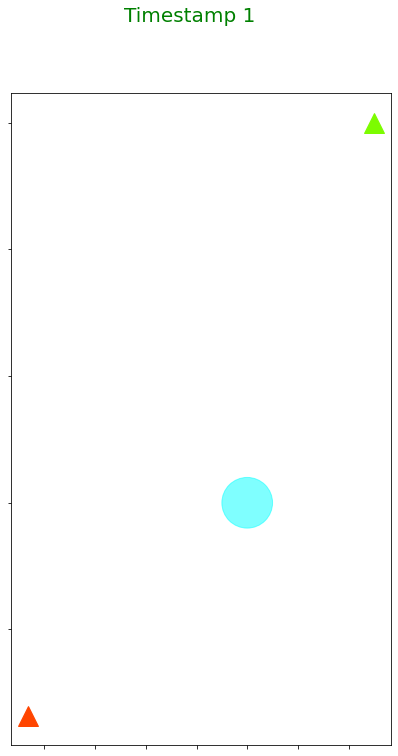

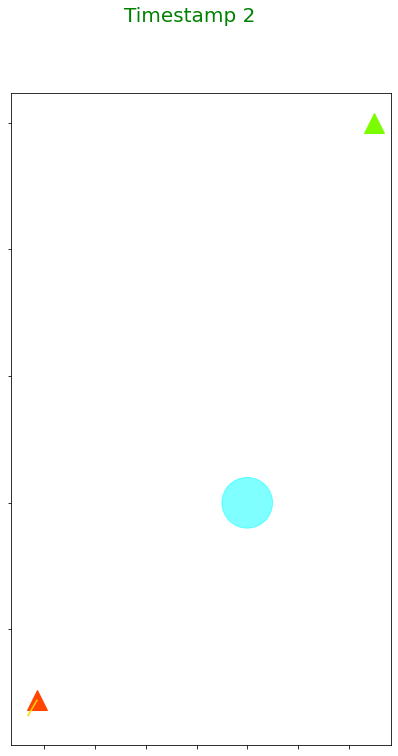

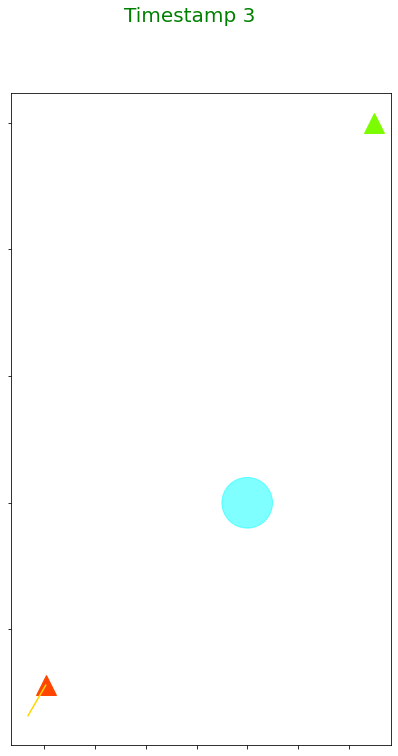

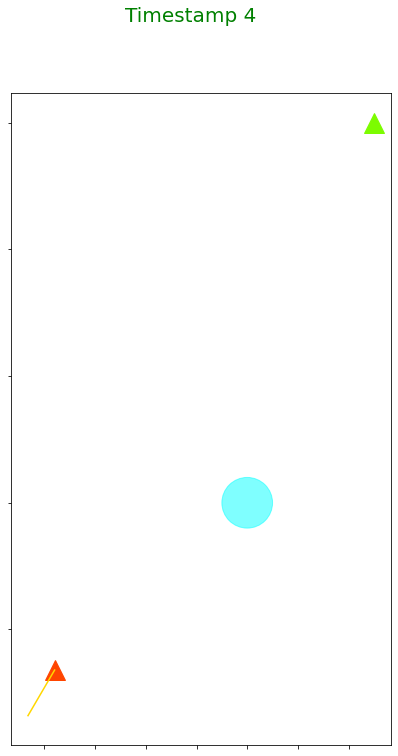

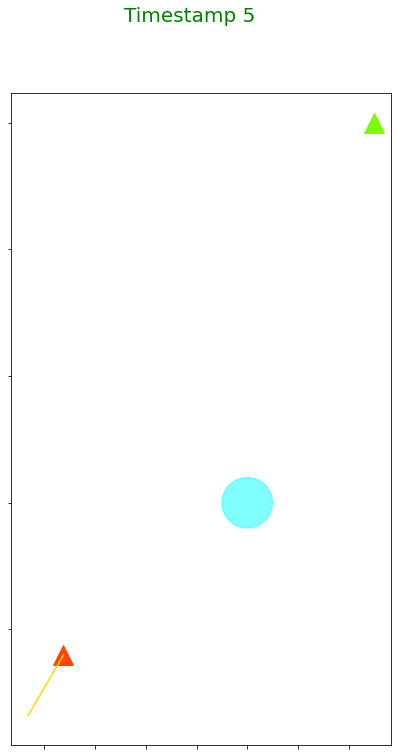

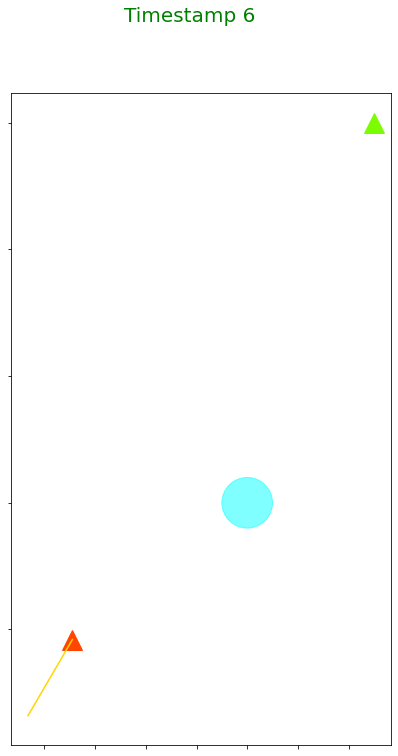

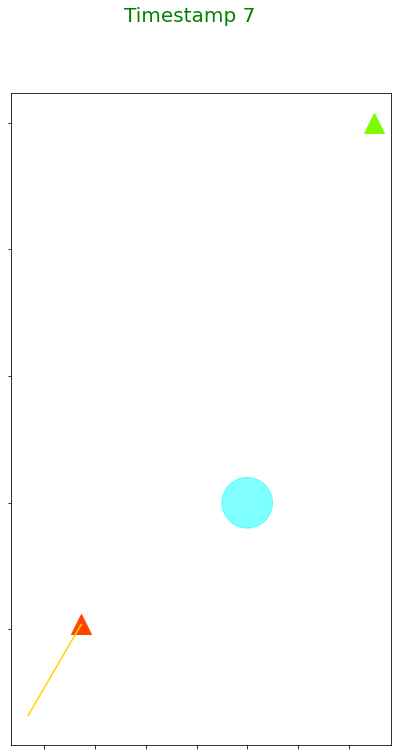

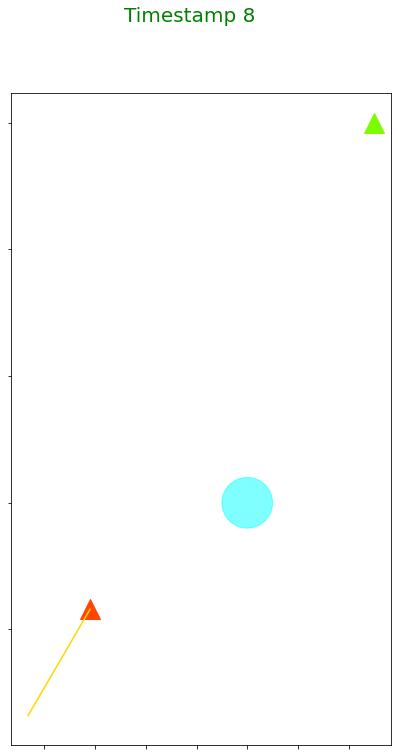

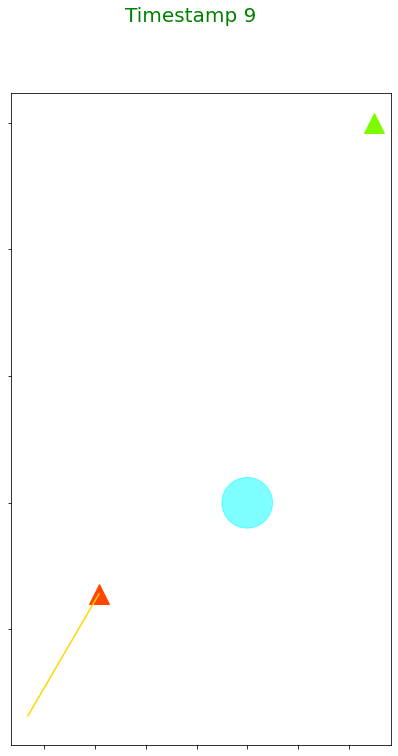

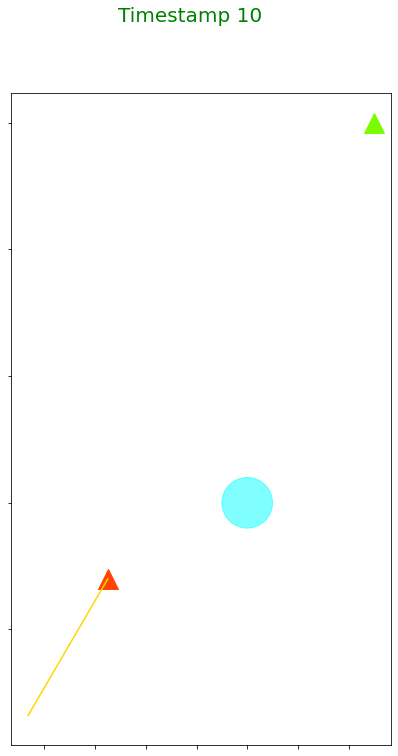

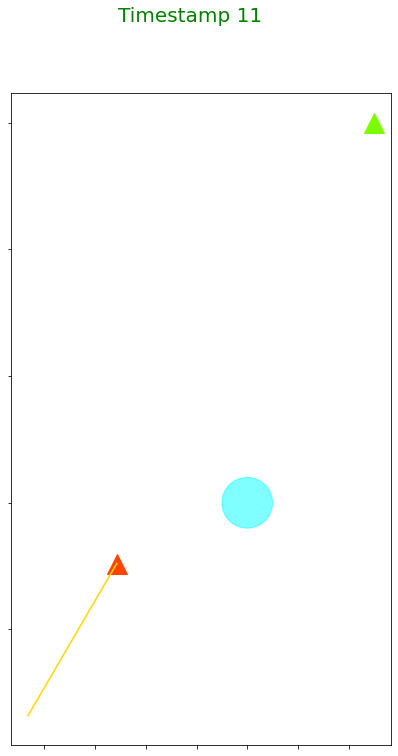

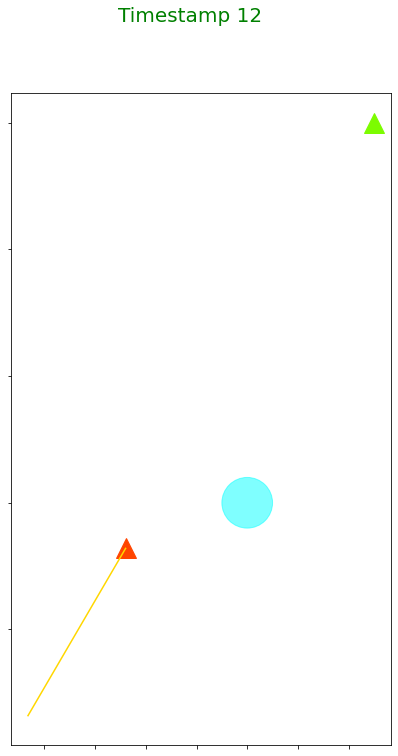

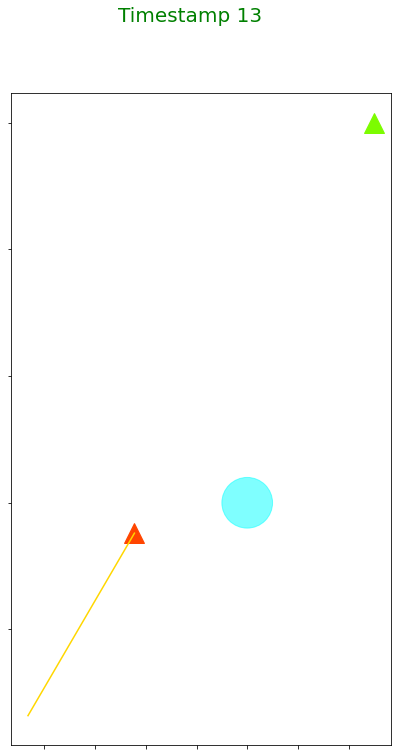

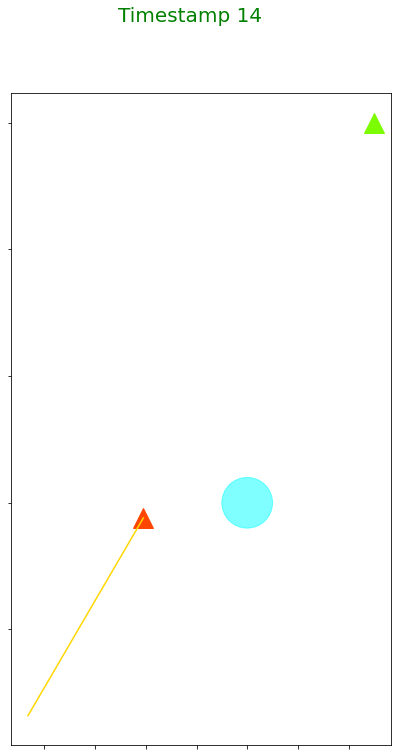

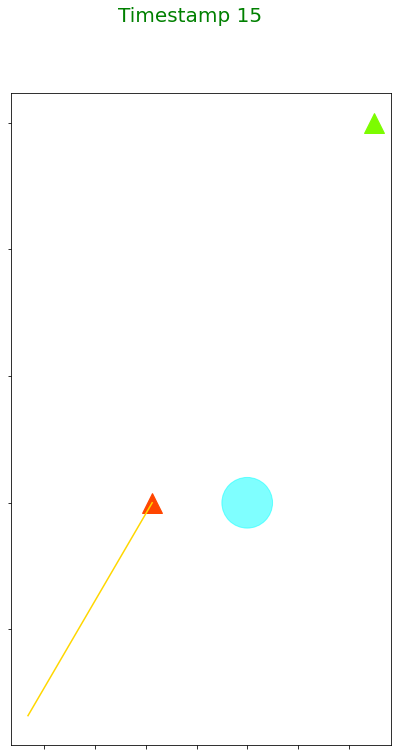

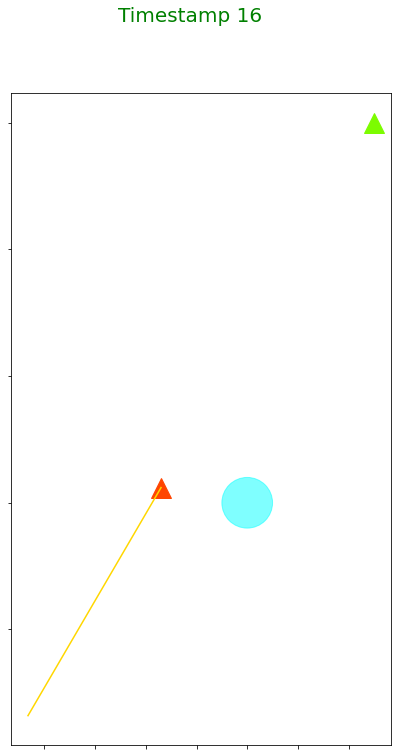

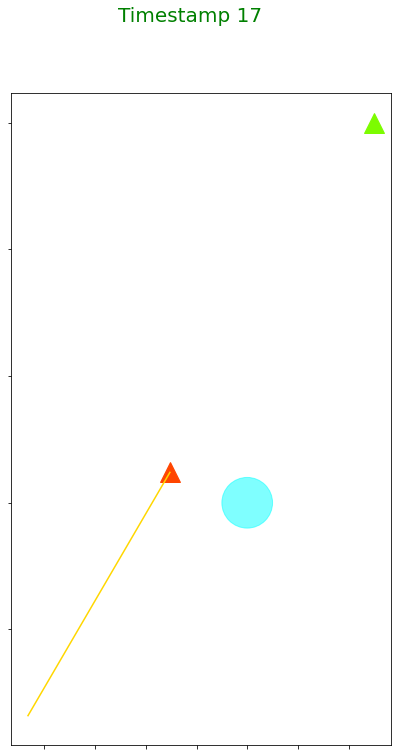

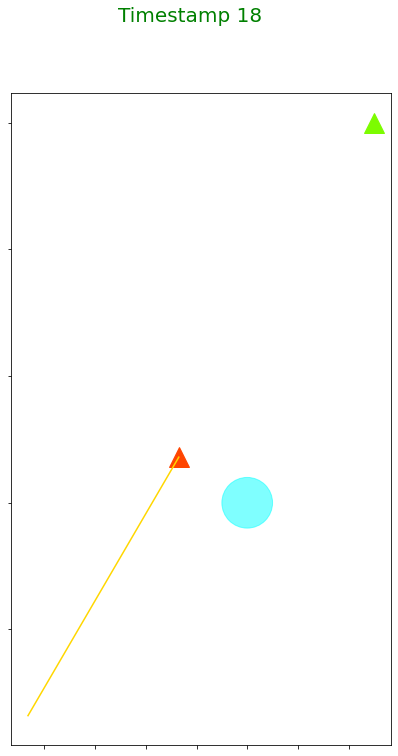

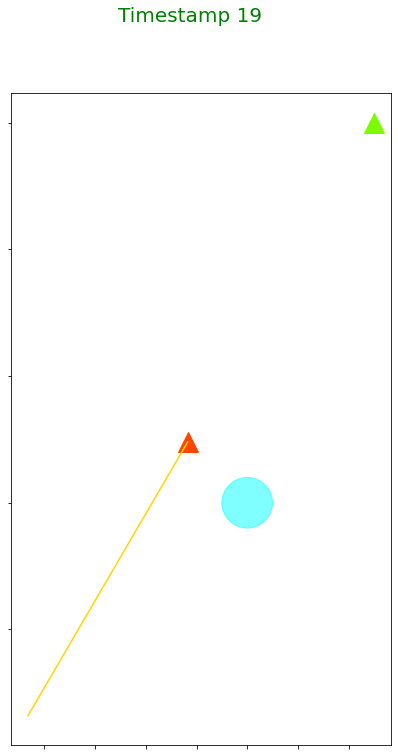

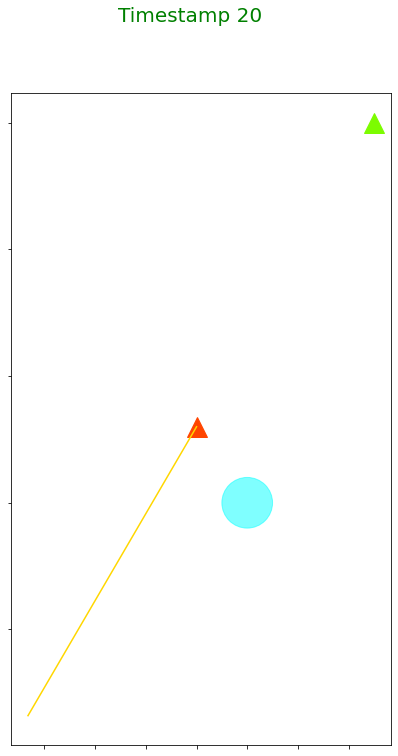

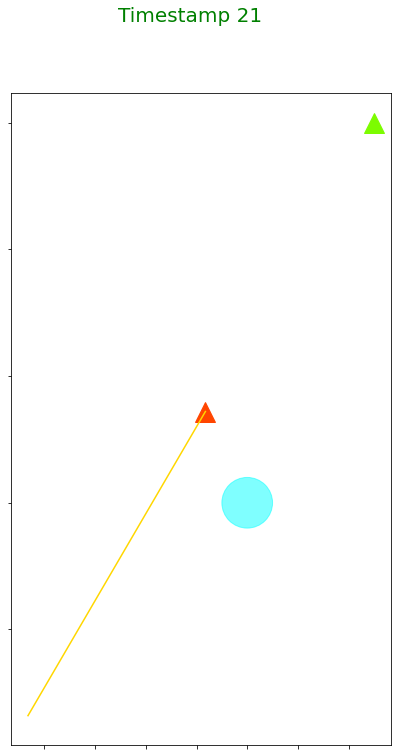

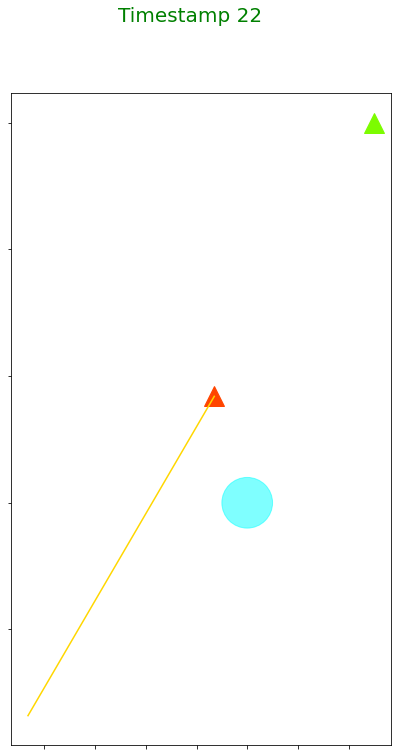

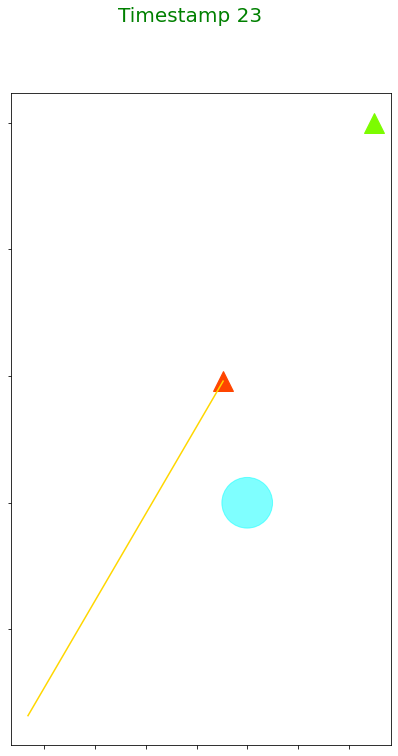

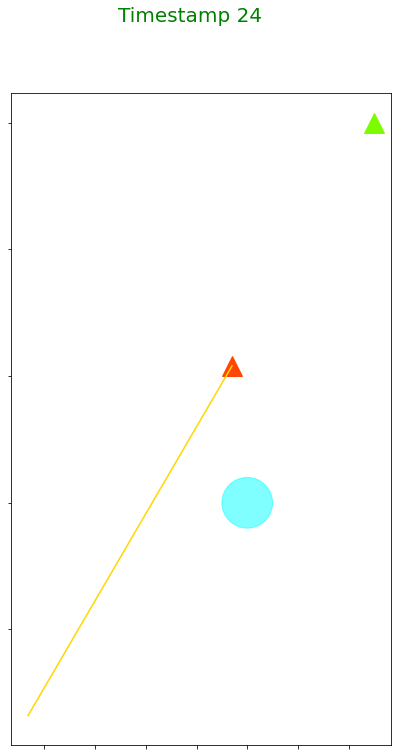

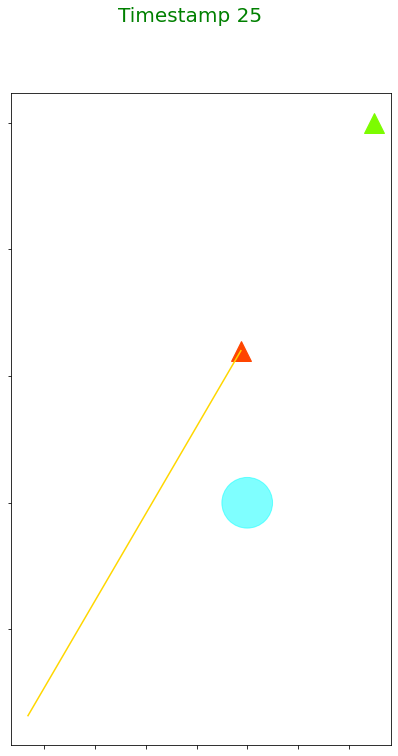

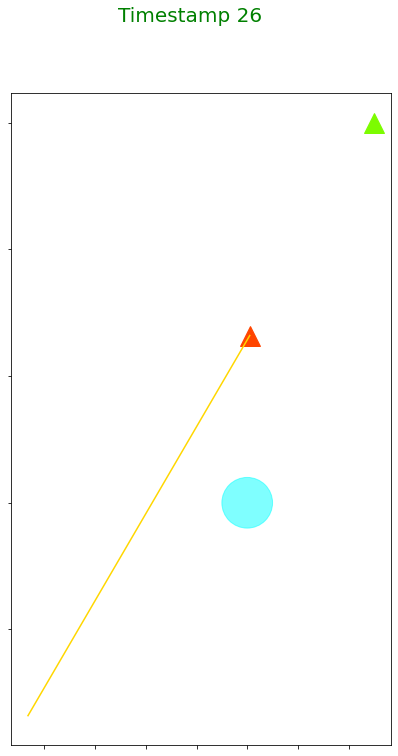

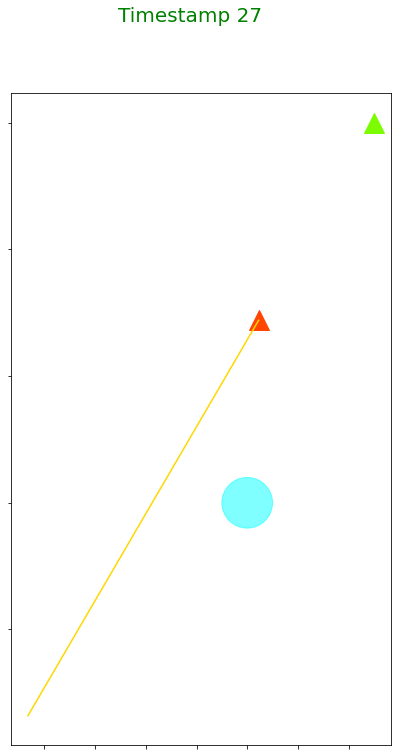

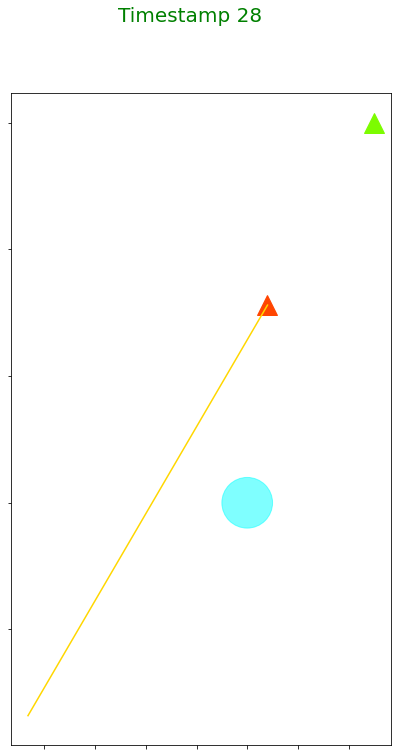

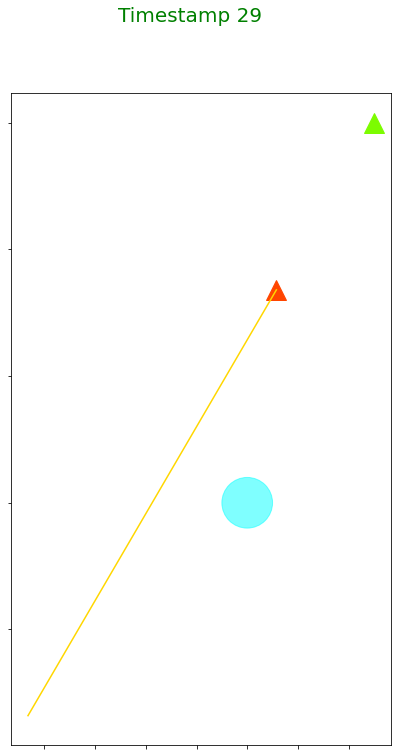

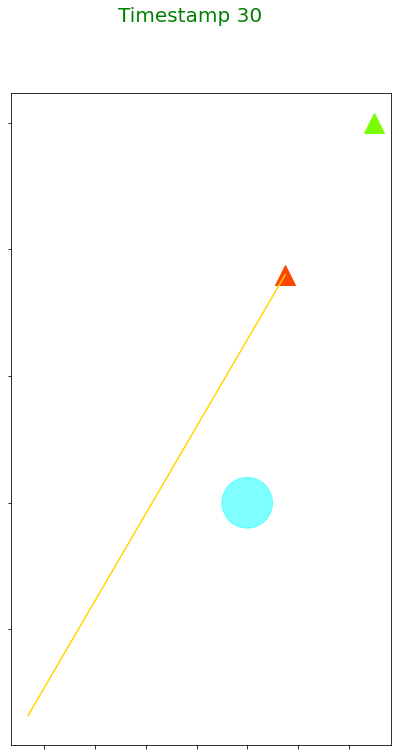

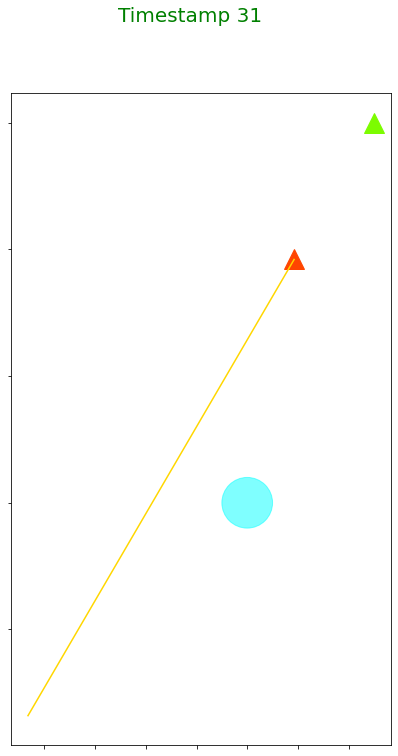

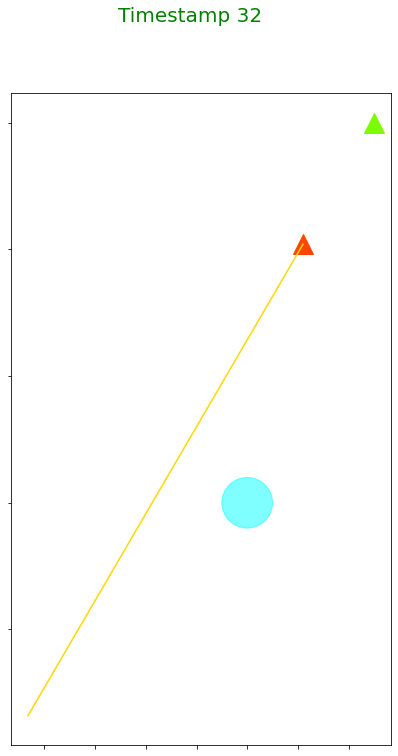

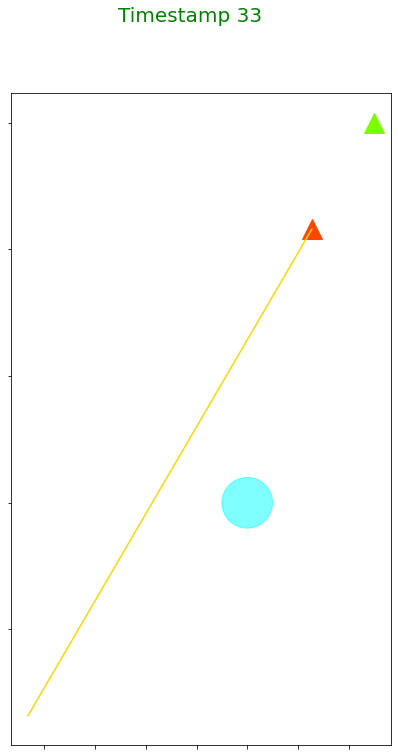

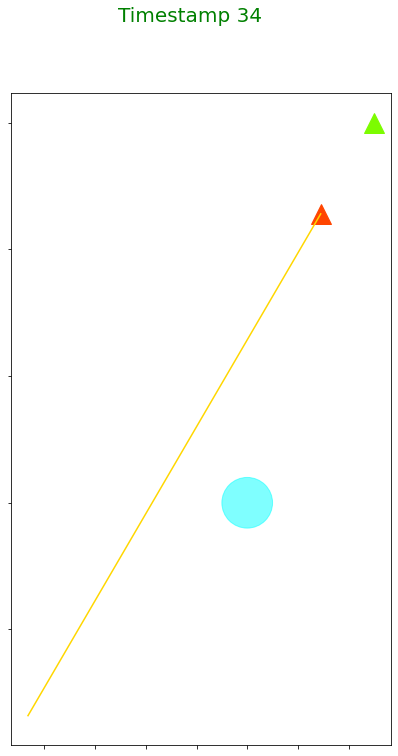

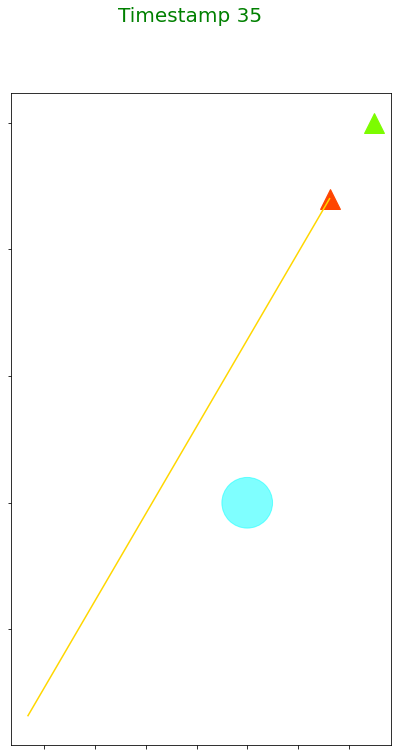

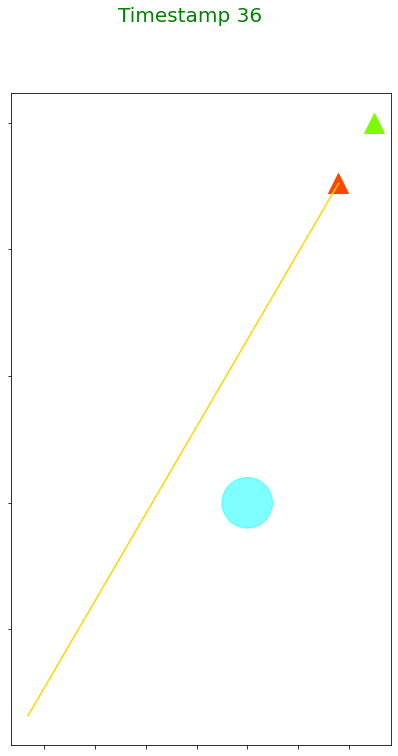

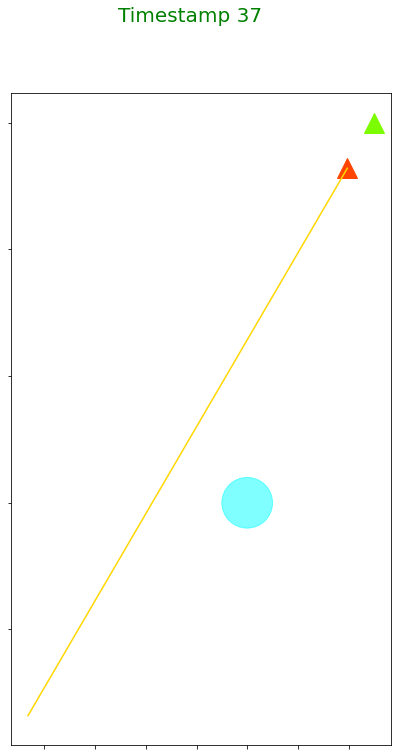

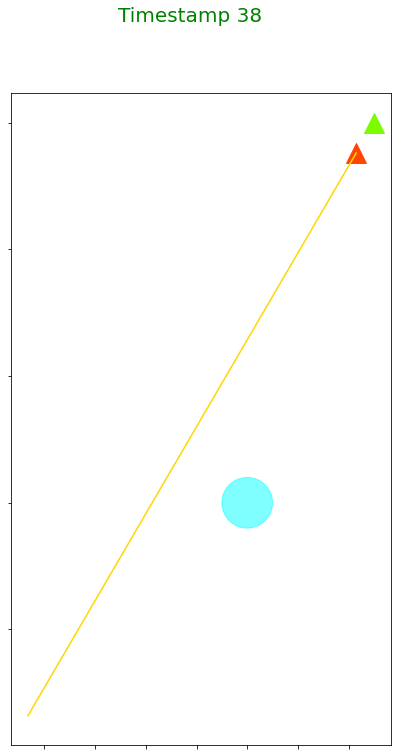

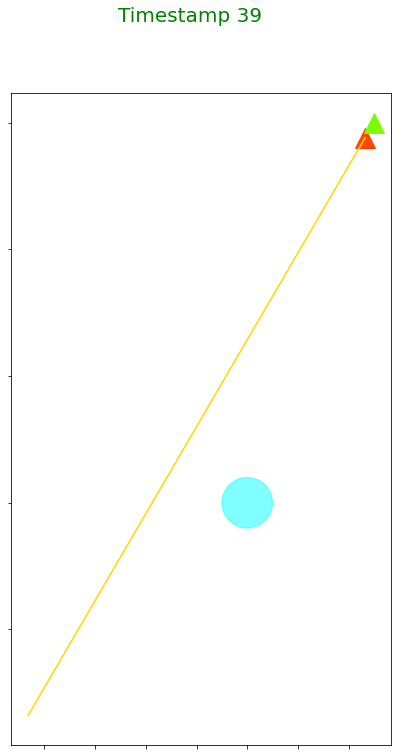

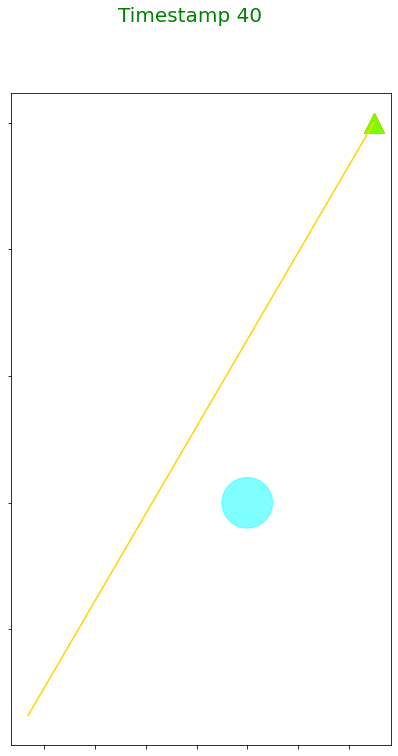

In [57]:
bot = MPC_Agent(np.array([1.0,1.0]),np.array([15.0,25.0]),40, 3)
bot.traj_opti()